# PROJECT IMPLEMENTATION- CA1
## Mohit Jain
## x18200991
## Msc in Data Analytics

## Case Study on London-Birmingham train route
Assumptions:
1. Max acceleration 0.76 m/s^2
2. Max travelling speed of train is 310 km/h
3. Ignoring air resistance
4. This route consist of sequence of signaling blocks (considering all blocks with same length), and one train at a time passes through each block. green means ready to go and red means stop, after 5 sec of train passing signal changes to green.

In [1]:
#importing relevant libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import simpy # for simulation
import simpy.events as evt
from scipy.optimize import linprog
import random
from random import sample


# Part 1: Simulation 
Distance between the interchange is 145 KM.
Considering the number of block in this case to be k=9

1. Creating a Simulation model of london old oak commons to birmingham interchange section of high speed line.
2. Another Simulation model with the delay of 30 mins at 9am

In [2]:
# this function generates time to reach birmingham from london with maximum velocity.
def time(acc, velo, s):
# acc       constant acceleration, m/s^2
# velo    maximumum velocity, m/s
# s       distance, km
# return  time in seconds required to travel
    timetoacc = velo/acc         # time taken to accelerate to max velo
    dis_trav = acc*timetoacc**2        # distance traveled during acceleration from 0 to max velo and drops to 0
    if (s < dis_trav):        
        return np.sqrt(4.0*s/acc)     # time needed to accelerate to half-way point then decelerate to destination
    else:
        return 2*timetoacc + (s-dis_trav)/velo 

In [3]:
# this function is responsible for creating the dataframes based on number of blocks
def datafra(N):
    blocks = pd.DataFrame()
    for i in range(N): 
                blocks.at[i, 'Initial'] = 'B' + str(i+1)
                blocks.at[i, 'Destination'] = 'B' + str(i+2)
    
    return blocks

In [4]:
# this function is responsible for adding content in dataframe which is created in previous function 
# like Distance, Actual Travel Time, Delay time
def datafra_add(k):
    
    data_add = datafra(k - 1)
    # Distance is equally divided based on number of blocks
    total_dist = 145000
    distance_div = total_dist / (k - 1)
    
    data_add['Distance'] = distance_div
    data_add['Travelling Time'] = ''
    data_add['Delay during the journey'] = np.random.normal(3.35,0.9, size= k - 1)     
    return data_add

In [28]:
k = 9 #number of signal blocks
# changing datatype of all the variables from text to int
data_add = datafra_add(k)
data_add['Distance']=data_add['Distance'].apply(lambda x: int(x))
data_add['Delay during the journey']=data_add['Delay during the journey'].apply(lambda x: int(x))
# changing station name which are known.
data_add['Initial'] = data_add['Initial'].replace(['B1'],'London Station')
data_add['Destination'] = data_add['Destination'].replace(['B'+str(k)],'Birmingham Station')
data_add['Total Time'] = time(0.76, 86.1, 145000)/(k-1) #time taken to reach destination with max speed.
# adding the delay time and total time taken to reach each signal
data_add['Travelling Time'] = data_add['Delay during the journey'] + data_add['Total Time'] 
data_add['Index number'] = data_add.index
data_add

,Initial,Destination,Distance,Travelling Time,Delay during the journey,Total Time,Index number
0,London Station,B2,18125,226.672218,2,224.672218,0
1,B2,B3,18125,225.672218,1,224.672218,1
2,B3,B4,18125,228.672218,4,224.672218,2
3,B4,B5,18125,227.672218,3,224.672218,3
4,B5,B6,18125,226.672218,2,224.672218,4
5,B6,B7,18125,226.672218,2,224.672218,5
6,B7,B8,18125,226.672218,2,224.672218,6
7,B8,Birmingham Station,18125,228.672218,4,224.672218,7


In [29]:
simulation_delay = []
for i in range(len(data_add)):
    simulation_delay.append(random.uniform(k*0.07,k*0.10))
data_add["Travelling Time"] =  data_add["Travelling Time"] + sample(simulation_delay,1)
data_add

,Initial,Destination,Distance,Travelling Time,Delay during the journey,Total Time,Index number
0,London Station,B2,18125,227.407563,2,224.672218,0
1,B2,B3,18125,226.407563,1,224.672218,1
2,B3,B4,18125,229.407563,4,224.672218,2
3,B4,B5,18125,228.407563,3,224.672218,3
4,B5,B6,18125,227.407563,2,224.672218,4
5,B6,B7,18125,227.407563,2,224.672218,5
6,B7,B8,18125,227.407563,2,224.672218,6
7,B8,Birmingham Station,18125,229.407563,4,224.672218,7


In [30]:
# this class contain the initial point where the train starts and the end point.
# considering the actual travelling time and delay time
class Train(object):
        def __init__(self, i, data_add, maxP = 600):
            self.name = ' [Train '+f"{i:2d}"+']'
            self.data_add = data_add
            self.maxP = maxP
            self.p = 0
     
     
        def process(self):
            for number in self.data_add['Index number']:
                count = 0
                datafra = self.data_add[self.data_add['Index number'] == number]
                Initial = datafra['Initial'].tolist()
                Destination = datafra['Destination'].tolist()
                Initial = Initial[0]
                Destination = Destination[0]
                for loc in datafra['Initial']:
                    data_new=data_add[data_add['Initial'] == loc]
                    travel_time=data_new.iloc[0].at['Travelling Time']
                    delay_time=data_new.iloc[0].at['Delay during the journey']
                    if number == 0:
                        yield environ.timeout(100)
                    print(f"{now():s} {self.name:s} dep from {Initial:s} for {Destination:s}")
                    yield environ.timeout(travel_time)
                    print(f"{now():s} {self.name:s} arr {Destination:s}")

## Simulation of train route without any delay from London to Birmingham

In [31]:
# this function is defined without considering any delay or breakdown of the train.
def withoutdelay_line(start=8*3600, stop=14*3600, timing=420):
        yield environ.timeout(start-environ.now)
        for i in range(int((stop-start)/timing)):
            p = Train(i, data_add)
            environ.process(p.process())
            yield environ.timeout(timing)
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(environ.now)

In [32]:
environ = simpy.Environment()   
environ.process(withoutdelay_line())
environ.run()

08:01:40  [Train  0] dep from London Station for B2
08:05:27  [Train  0] arr B2
08:05:27  [Train  0] dep from B2 for B3
08:08:40  [Train  1] dep from London Station for B2
08:09:13  [Train  0] arr B3
08:09:13  [Train  0] dep from B3 for B4
08:12:27  [Train  1] arr B2
08:12:27  [Train  1] dep from B2 for B3
08:13:03  [Train  0] arr B4
08:13:03  [Train  0] dep from B4 for B5
08:15:40  [Train  2] dep from London Station for B2
08:16:13  [Train  1] arr B3
08:16:13  [Train  1] dep from B3 for B4
08:16:51  [Train  0] arr B5
08:16:51  [Train  0] dep from B5 for B6
08:19:27  [Train  2] arr B2
08:19:27  [Train  2] dep from B2 for B3
08:20:03  [Train  1] arr B4
08:20:03  [Train  1] dep from B4 for B5
08:20:39  [Train  0] arr B6
08:20:39  [Train  0] dep from B6 for B7
08:22:40  [Train  3] dep from London Station for B2
08:23:13  [Train  2] arr B3
08:23:13  [Train  2] dep from B3 for B4
08:23:51  [Train  1] arr B5
08:23:51  [Train  1] dep from B5 for B6
08:24:26  [Train  0] arr B7
08:24:26  [Train

10:04:27  [Train 17] dep from B2 for B3
10:05:03  [Train 16] arr B4
10:05:03  [Train 16] dep from B4 for B5
10:05:39  [Train 15] arr B6
10:05:39  [Train 15] dep from B6 for B7
10:06:13  [Train 14] arr B8
10:06:13  [Train 14] dep from B8 for Birmingham Station
10:07:40  [Train 18] dep from London Station for B2
10:08:13  [Train 17] arr B3
10:08:13  [Train 17] dep from B3 for B4
10:08:51  [Train 16] arr B5
10:08:51  [Train 16] dep from B5 for B6
10:09:26  [Train 15] arr B7
10:09:26  [Train 15] dep from B7 for B8
10:10:03  [Train 14] arr Birmingham Station
10:11:27  [Train 18] arr B2
10:11:27  [Train 18] dep from B2 for B3
10:12:03  [Train 17] arr B4
10:12:03  [Train 17] dep from B4 for B5
10:12:39  [Train 16] arr B6
10:12:39  [Train 16] dep from B6 for B7
10:13:13  [Train 15] arr B8
10:13:13  [Train 15] dep from B8 for Birmingham Station
10:14:40  [Train 19] dep from London Station for B2
10:15:13  [Train 18] arr B3
10:15:13  [Train 18] dep from B3 for B4
10:15:51  [Train 17] arr B5
10:1

12:01:26  [Train 31] dep from B7 for B8
12:02:03  [Train 30] arr Birmingham Station
12:03:27  [Train 34] arr B2
12:03:27  [Train 34] dep from B2 for B3
12:04:03  [Train 33] arr B4
12:04:03  [Train 33] dep from B4 for B5
12:04:39  [Train 32] arr B6
12:04:39  [Train 32] dep from B6 for B7
12:05:13  [Train 31] arr B8
12:05:13  [Train 31] dep from B8 for Birmingham Station
12:06:40  [Train 35] dep from London Station for B2
12:07:13  [Train 34] arr B3
12:07:13  [Train 34] dep from B3 for B4
12:07:51  [Train 33] arr B5
12:07:51  [Train 33] dep from B5 for B6
12:08:26  [Train 32] arr B7
12:08:26  [Train 32] dep from B7 for B8
12:09:03  [Train 31] arr Birmingham Station
12:10:27  [Train 35] arr B2
12:10:27  [Train 35] dep from B2 for B3
12:11:03  [Train 34] arr B4
12:11:03  [Train 34] dep from B4 for B5
12:11:39  [Train 33] arr B6
12:11:39  [Train 33] dep from B6 for B7
12:12:13  [Train 32] arr B8
12:12:13  [Train 32] dep from B8 for Birmingham Station
12:13:40  [Train 36] dep from London Sta

13:49:39  [Train 47] dep from B6 for B7
13:50:13  [Train 46] arr B8
13:50:13  [Train 46] dep from B8 for Birmingham Station
13:51:40  [Train 50] dep from London Station for B2
13:52:13  [Train 49] arr B3
13:52:13  [Train 49] dep from B3 for B4
13:52:51  [Train 48] arr B5
13:52:51  [Train 48] dep from B5 for B6
13:53:26  [Train 47] arr B7
13:53:26  [Train 47] dep from B7 for B8
13:54:03  [Train 46] arr Birmingham Station
13:55:27  [Train 50] arr B2
13:55:27  [Train 50] dep from B2 for B3
13:56:03  [Train 49] arr B4
13:56:03  [Train 49] dep from B4 for B5
13:56:39  [Train 48] arr B6
13:56:39  [Train 48] dep from B6 for B7
13:57:13  [Train 47] arr B8
13:57:13  [Train 47] dep from B8 for Birmingham Station
13:59:13  [Train 50] arr B3
13:59:13  [Train 50] dep from B3 for B4
13:59:51  [Train 49] arr B5
13:59:51  [Train 49] dep from B5 for B6
14:00:26  [Train 48] arr B7
14:00:26  [Train 48] dep from B7 for B8
14:01:03  [Train 47] arr Birmingham Station
14:03:03  [Train 50] arr B4
14:03:03  [T

The simulation without any delay starts from 8:00 AM to 2:00 PM and total 50 trains can run with the max speed and read to the destination, following 9 signals simutaneously.
The last train reach at 2:22:03 PM.

## Simulation of train route with the delay at 9am and from London to Birmingham 

In [33]:
# this function is defined adding the delay at 9am train and the shows the corresponding simulated below
def delay_line(start=8*3600, stop=14*3600, timing=420):
        yield environ.timeout(start-environ.now)
        for i in range(int((stop-start)/timing)):
            if i==35:
                yield environ.timeout(1800)
            p = Train(i, data_add)
            environ.process(p.process())
            yield environ.timeout(timing)
         
         
         
def daytime(p):
    p=int(p)
    return f"{p//3600:02d}:{(p%3600)//60:02d}:{p%60:02d}"
def now():
    return daytime(environ.now)

In [34]:
environ = simpy.Environment()   
environ.process(delay_line())
environ.run()

08:01:40  [Train  0] dep from London Station for B2
08:05:27  [Train  0] arr B2
08:05:27  [Train  0] dep from B2 for B3
08:08:40  [Train  1] dep from London Station for B2
08:09:13  [Train  0] arr B3
08:09:13  [Train  0] dep from B3 for B4
08:12:27  [Train  1] arr B2
08:12:27  [Train  1] dep from B2 for B3
08:13:03  [Train  0] arr B4
08:13:03  [Train  0] dep from B4 for B5
08:15:40  [Train  2] dep from London Station for B2
08:16:13  [Train  1] arr B3
08:16:13  [Train  1] dep from B3 for B4
08:16:51  [Train  0] arr B5
08:16:51  [Train  0] dep from B5 for B6
08:19:27  [Train  2] arr B2
08:19:27  [Train  2] dep from B2 for B3
08:20:03  [Train  1] arr B4
08:20:03  [Train  1] dep from B4 for B5
08:20:39  [Train  0] arr B6
08:20:39  [Train  0] dep from B6 for B7
08:22:40  [Train  3] dep from London Station for B2
08:23:13  [Train  2] arr B3
08:23:13  [Train  2] dep from B3 for B4
08:23:51  [Train  1] arr B5
08:23:51  [Train  1] dep from B5 for B6
08:24:26  [Train  0] arr B7
08:24:26  [Train

09:54:51  [Train 14] dep from B5 for B6
09:55:26  [Train 13] arr B7
09:55:26  [Train 13] dep from B7 for B8
09:56:03  [Train 12] arr Birmingham Station
09:57:27  [Train 16] arr B2
09:57:27  [Train 16] dep from B2 for B3
09:58:03  [Train 15] arr B4
09:58:03  [Train 15] dep from B4 for B5
09:58:39  [Train 14] arr B6
09:58:39  [Train 14] dep from B6 for B7
09:59:13  [Train 13] arr B8
09:59:13  [Train 13] dep from B8 for Birmingham Station
10:00:40  [Train 17] dep from London Station for B2
10:01:13  [Train 16] arr B3
10:01:13  [Train 16] dep from B3 for B4
10:01:51  [Train 15] arr B5
10:01:51  [Train 15] dep from B5 for B6
10:02:26  [Train 14] arr B7
10:02:26  [Train 14] dep from B7 for B8
10:03:03  [Train 13] arr Birmingham Station
10:04:27  [Train 17] arr B2
10:04:27  [Train 17] dep from B2 for B3
10:05:03  [Train 16] arr B4
10:05:03  [Train 16] dep from B4 for B5
10:05:39  [Train 15] arr B6
10:05:39  [Train 15] dep from B6 for B7
10:06:13  [Train 14] arr B8
10:06:13  [Train 14] dep fro

11:58:13  [Train 30] arr B8
11:58:13  [Train 30] dep from B8 for Birmingham Station
11:59:40  [Train 34] dep from London Station for B2
12:00:13  [Train 33] arr B3
12:00:13  [Train 33] dep from B3 for B4
12:00:51  [Train 32] arr B5
12:00:51  [Train 32] dep from B5 for B6
12:01:26  [Train 31] arr B7
12:01:26  [Train 31] dep from B7 for B8
12:02:03  [Train 30] arr Birmingham Station
12:03:27  [Train 34] arr B2
12:03:27  [Train 34] dep from B2 for B3
12:04:03  [Train 33] arr B4
12:04:03  [Train 33] dep from B4 for B5
12:04:39  [Train 32] arr B6
12:04:39  [Train 32] dep from B6 for B7
12:05:13  [Train 31] arr B8
12:05:13  [Train 31] dep from B8 for Birmingham Station
12:07:13  [Train 34] arr B3
12:07:13  [Train 34] dep from B3 for B4
12:07:51  [Train 33] arr B5
12:07:51  [Train 33] dep from B5 for B6
12:08:26  [Train 32] arr B7
12:08:26  [Train 32] dep from B7 for B8
12:09:03  [Train 31] arr Birmingham Station
12:11:03  [Train 34] arr B4
12:11:03  [Train 34] dep from B4 for B5
12:11:39  [T

14:33:39  [Train 49] dep from B6 for B7
14:34:13  [Train 48] arr B8
14:34:13  [Train 48] dep from B8 for Birmingham Station
14:36:51  [Train 50] arr B5
14:36:51  [Train 50] dep from B5 for B6
14:37:26  [Train 49] arr B7
14:37:26  [Train 49] dep from B7 for B8
14:38:03  [Train 48] arr Birmingham Station
14:40:39  [Train 50] arr B6
14:40:39  [Train 50] dep from B6 for B7
14:41:13  [Train 49] arr B8
14:41:13  [Train 49] dep from B8 for Birmingham Station
14:44:26  [Train 50] arr B7
14:44:26  [Train 50] dep from B7 for B8
14:45:03  [Train 49] arr Birmingham Station
14:48:13  [Train 50] arr B8
14:48:13  [Train 50] dep from B8 for Birmingham Station
14:52:03  [Train 50] arr Birmingham Station


By adding the delay on the same simulation the last train reaches the destination is 2:52:03 PM which is after 30 mins of delay.

# Part 2: Optimisation  

The aim is to find the maximum numbers of trains that can be operated in an hour using the same simulation on the same route with the same constraint above.
1. Constraint for optimization is that the average delay time should not be higher than half the scheduled time between consecutive trains.
2. First train leaves at 7am and last train leaves at 10 pm

Load Dataset

In [55]:
dataframe=pd.read_csv('Optimization.csv')

## The below dataframe is generated by changing numbers of blocks on the above simulation model. And later this obtained results are saved in seperate CSV file.


In [56]:
# Travel Optimization
simulation_data = dataframe
simulation_data

,Number_of_Blocks,Number_of_trains,Average_delay_time,Time_between_consecutive_trains
0,8,47,2.833,5
1,9,50,2.500,7
2,10,53,2.450,9
3,11,56,2.120,11


In [67]:
# Travel Optimization
simulation_data = dataframe
pd.options.mode.chained_assignment = None
 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np

pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['Number_of_trains'])
predictor = pd.DataFrame(simulation_data[['Number_of_Blocks', 'Average_delay_time', 'Time_between_consecutive_trains']])
predictor = sm.add_constant(predictor)
 
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

C:\Users\jnmht\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Number_of_trains   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.999e+26
Date:                Fri, 28 Aug 2020   Prob (F-statistic):           4.08e-14
Time:                        23:18:38   Log-Likelihood:                 112.80
No. Observations:                   4   AIC:                            -219.6
Df Residuals:                       1   BIC:                            -221.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.4365   3.11e-13   4.62e+12      0.000       1.437       1.437
Number_of_Blocks                    6.9206   1.27e-12   5.44e+12      0.000       6.921       6.921
Average_delay_time               7.816e-14   2.18e-12      0.036      0.977   -2.76e-11    2.77e-11
Time_between_consecutive_trains    -1.9603   8.79e-13  -2.23e+12      0.000      -1.960      -1.960
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.047
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.398
Skew:                          -0.190   Prob(JB):                        0.819
Kurtosis:                       1.501   Cond. No.                     3.91e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.35e-37. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [82]:
#linear regression to find objective function
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
 
def f(x,y):
    return 1.4365 + 6.9206*x + (-1.9603)*y

In [83]:
#monte carlo algorithm used for optimization
import random
random.seed(0)
 
def montecarlo(n, x_min=4, x_max=11, y_min=6, y_max=10):
    x = [ random.randint(x_min, x_max) for i in range(n)]
    y = [ random.randint(y_min, y_max) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    fmin = f(xp[0], yp[0])
    
    for i in range(1, len(x)):
        fi = f(x[i], y[i])
 
        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi
 
        xs = np.linspace(x_min, x_max, 100)
        ys = np.linspace(y_min, y_max, 100)
        xx, yy = np.meshgrid(xs, ys)
        z=f(xx, yy)
        
        fig, ax = plt.subplots(1, 1)
        fig.set_figwidth(6)
        fig.set_figheight(5)
        cs = ax.contourf(xs, ys, z, 100)
        fig.colorbar(cs, ax=ax)
        
        plt.scatter(x, y, c='red', marker='.')
        plt.plot(xp, yp, c='red')
        
        return len(xp), xp[-1], yp[-1], f(xp[-1], yp[-1])

(1, 8, 6, 45.039500000000004)

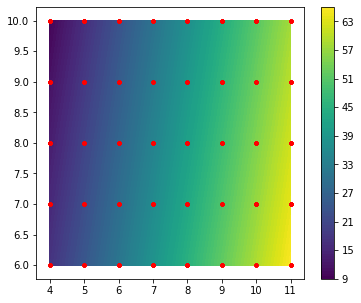

In [84]:
random.seed(400)
montecarlo(500)

(1, 9, 10, 44.11890000000001)

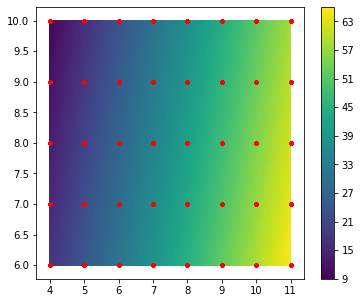

In [85]:
random.seed(300)
montecarlo(500)

(1, 8, 10, 37.1983)

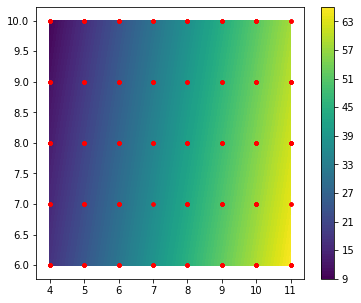

In [86]:
random.seed(600)
montecarlo(500)

(1, 5, 10, 16.436500000000006)

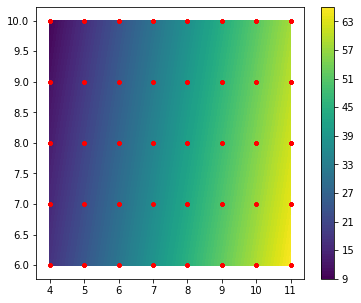

In [87]:
random.seed(450)
montecarlo(500)

# From the Monte Carlo Optimization, we can see that the optimal solution which is maximum numbers of trains is 45, when blocks is 8 and distance between two consecutive trains is 6.